In [40]:
import os

subj = "Subj1"
N_STAGES = 9
RERUN = True
N_THRESHOLDS = 15

exp = "exp_select_features_by_function"
features_type = 'src'
function = 'best_square_multiple' # best_silh, best_multiple, best_log_multiple, best_sqrt_multiple, best_square_multiple
os.makedirs(f"{subj}/{exp}/{features_type}/{function}", exist_ok = True)

In [41]:
%load_ext autoreload
%autoreload 2

import typing
import warnings
warnings.filterwarnings('ignore')

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import umap
import tqdm
import numpy
import pandas
import joblib
import sklearn.metrics
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
import matplotlib.pyplot as plt
import sklearn.feature_selection
import sklearn.cross_decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def explained_variance(features, reduced):
    pls = sklearn.cross_decomposition.PLSRegression(n_components = reduced.shape[1])
    y_pred = pls.fit(reduced, features).predict(reduced)
    return sklearn.metrics.r2_score(features, y_pred, multioutput = "variance_weighted")

### Selection

In [43]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
df_features = pandas.read_feather(f'{subj}/{features_type}/all_features.feather')
print(df_features.shape)

features = sklearn.preprocessing.StandardScaler().fit_transform(df_features)
print(features.shape)

params = {
    'n_clusters_min': 2, 'n_clusters_max': 10,
    'k_neighbours': range(20, 51, 3),

    'st1_merging': SDA.StageMerging.BOTH,
    'st1_len_thresholds': 40,

    'n_cl_max_thr': [ 20 ],
    'k_neighb_max_thr': [ 50 ],
    'n_edge_clusters_min': 2, 'n_edge_clusters_max': 10,

    'st1_merging': SDA.StageMerging.BOTH,
    'st2_len_thresholds': 40,
}

(1046, 765)
(1046, 765)


In [44]:
def generate_merges(features: numpy.ndarray, st_edges: numpy.ndarray) -> typing.Set[typing.Tuple[int]]:
    if len(st_edges) < 3: return set()
    edges1 = SDA.stageprocess.merge_stages_1st_step_iter(features, st_edges)
    edges2 = SDA.stageprocess.merge_stages_2nd_step_iter(features, st_edges)
    merges1 = generate_merges(features, edges1)
    merges2 = generate_merges(features, edges2)
    return set([ tuple(st_edges) ]) | merges1 | merges2

def calc_score(features: numpy.ndarray, st_edges: numpy.ndarray) -> float:
    metrics = SDA.clustquality.calc_stage_metr_noground(features, st_edges, [ 'Silh' ]).mean()
    match function:
        case 'best_silh':
            return metrics['Silh']
        case 'best_multiple':
            return len(st_edges) * metrics['Silh']
        case 'best_log_multiple':
            return numpy.log2(len(st_edges)) * metrics['Silh']
        case 'best_sqrt_multiple':
            return numpy.sqrt(len(st_edges)) * metrics['Silh']
        case 'best_square_multiple':
            return len(st_edges) * len(st_edges) * metrics['Silh']
    raise NotImplementedError(function)

def score_feature(i: int, n_jobs: int = 1, verbose: bool = False):
    sda = SDA.SDA(**params, scale = False, st1_calc_quality = False, st2_calc_quality = False, n_jobs = n_jobs, verbose = verbose)

    feature = features[:, i].reshape(-1, 1)
    results, _ = sda.apply(feature)

    edges_lists = set()
    for edges in map(numpy.array, set(map(tuple, results["St_edges"]))):
        edges_lists |= generate_merges(feature, edges)

    score = numpy.max([
        calc_score(feature, numpy.array(merge))
        for merge in edges_lists
    ])
    
    return {
        'index': i,
        'name': df_features.columns[i],
        'score': score,
        'mean': feature.mean(),
        'variance': feature.var(),
        'unique_values': len(numpy.unique(feature))
    }

In [45]:
if RERUN:
    scores = joblib.Parallel(n_jobs = 14)(joblib.delayed(score_feature)(i) for i in tqdm.trange(features.shape[1]))
    scores = pandas.DataFrame(list(scores))
else:
    scores = pandas.read_csv(f"{subj}/{exp}/{features_type}/{function}/scores_{features_type[4:]}.csv")
display(scores)

100%|██████████| 765/765 [31:34<00:00,  2.48s/it]


,index,name,score,mean,variance,unique_values
0,0,D_psd_Fp,5.250989,4.211630e-16,1.0,1046
1,1,D_psd_LF,4.544935,-1.283868e-15,1.0,1046
2,2,D_psd_MF,4.513781,-1.949577e-15,1.0,1046
3,3,D_psd_RF,5.000024,4.395040e-15,1.0,1046
4,4,D_psd_LT,5.691523,2.309604e-16,1.0,1046
...,...,...,...,...,...,...
760,760,G_plv_MO_07,8.122655,-2.717181e-17,1.0,42
761,761,G_plv_MO_08,12.819355,7.608106e-16,1.0,50
762,762,G_plv_RO_06,5.272417,-2.717181e-16,1.0,40
763,763,G_plv_RO_07,5.650134,7.064670e-16,1.0,46


In [46]:
scores.to_csv(f"{subj}/{exp}/{features_type}/{function}/scores_{features_type[4:]}.csv", index = False)
display(scores.sort_values(by = 'score', ascending = False))

,index,name,score,mean,variance,unique_values
426,426,A_coh_MC_06,40.447080,-8.559119e-16,1.0,81
137,137,G_TA_psd_RF,40.351029,2.173745e-16,1.0,1046
429,429,A_coh_RC_06,39.998220,-3.124758e-16,1.0,117
380,380,T_coh_LC_08,39.589575,-1.358590e-16,1.0,85
400,400,T_coh_MO_07,37.726403,0.000000e+00,1.0,95
...,...,...,...,...,...,...
228,228,G_D_psd_LP,2.546254,4.143700e-16,1.0,1046
100,100,G_D_psd_LF,2.097620,9.510132e-17,1.0,1046
571,571,D_plv_MP_07,2.094251,-8.151542e-17,1.0,85
562,562,D_plv_MC_07,1.434974,5.026784e-16,1.0,107


### Tests

In [47]:
def test_threshold(dim_reducer, threshold):
    scores_sorted = scores.sort_values(by = 'score', ascending = False)
    feature_idx = scores_sorted[:threshold]["index"].to_numpy()
    best_features = features[:, feature_idx]
    
    reduced_features = dim_reducer.fit_transform(best_features)
    reduced_result, _ = SDA.SDA(n_jobs = 15, scale = False, verbose = False, st1_calc_quality = False).apply(reduced_features)

    try:
        reduced_best_result = SDA.analytics.best_result(reduced_result, key = 'Avg-Silh', n_stages = N_STAGES)
        reduced_edges = reduced_best_result['St_edges']
            
        return {
            'num_features': best_features.shape[1],
            'explained_variances_reduced': explained_variance(best_features, reduced_features),
            'explained_variances_all': explained_variance(features, reduced_features),
            'fmi': SDA.clustquality.cluster_metrics_ground(edges_true, reduced_edges, [ "FMI" ])["FMI"],
            'silh_15': SDA.clustquality.calc_stage_metr_noground(reduced_features, reduced_edges, [ "Silh" ]).mean()["Silh"],
            'silh_reduced': SDA.clustquality.calc_stage_metr_noground(best_features, reduced_edges, [ "Silh" ]).mean()["Silh"],
            'silh_all': SDA.clustquality.calc_stage_metr_noground(features, reduced_edges, [ "Silh" ]).mean()["Silh"]
        }
    
    except:
        return {
            'num_features': best_features.shape[1],
            'explained_variances_reduced': explained_variance(best_features, reduced_features),
            'explained_variances_all': explained_variance(features, reduced_features),
            'fmi': 0,
            'silh_15': 0,
            'silh_reduced': 0,
            'silh_all': 0
        }

In [48]:
def test_thresholds(dim_reducer):
    n_features = features.shape[1]
    thresholds = list(range(0, n_features, n_features // N_THRESHOLDS))[1:]

    results = joblib.Parallel(n_jobs = -1)(
        joblib.delayed(test_threshold)(dim_reducer, threshold)
        for threshold in tqdm.tqdm(thresholds)
    )

    df = pandas.DataFrame(results)
    display(df)

    fig, axes = plt.subplots(2, 2, figsize = (20, 7))

    axes[0][0].plot(thresholds, df["num_features"])
    axes[0][0].set_xlabel("Silh Threshold")
    axes[0][0].set_ylabel("Num features")

    axes[0][1].plot(thresholds, df["explained_variances_reduced"], label = 'reduced')
    axes[0][1].plot(thresholds, df["explained_variances_all"], label = 'all')
    axes[0][1].set_xlabel("Silh Threshold")
    axes[0][1].set_ylabel("Explained variance")
    axes[0][1].legend()

    axes[1][0].plot(thresholds, df["silh_15"], label = 'Silh - 15')
    axes[1][0].plot(thresholds, df["silh_reduced"], label = 'Silh - reduced')
    axes[1][0].plot(thresholds, df["silh_all"], label = 'Silh - all')
    axes[1][0].set_xlabel("Silh Threshold")
    axes[1][0].set_ylabel("Silh")
    axes[1][0].legend()

    axes[1][1].plot(thresholds, df["fmi"])
    axes[1][1].set_xlabel("Silh Threshold")
    axes[1][1].set_ylabel("FMI")

    fig.show()
    return df, fig

#### PCA

100%|██████████| 14/14 [00:00<00:00, 1645.10it/s]


,num_features,explained_variances_reduced,explained_variances_all,fmi,silh_15,silh_reduced,silh_all
0,51,0.927857,0.516407,0.719651,0.253955,0.232712,0.137710
1,102,0.871269,0.585493,0.788538,0.239633,0.204265,0.133958
2,153,0.840342,0.604432,0.671895,0.240054,0.197891,0.134501
3,204,0.827050,0.616884,0.676599,0.249886,0.201425,0.140130
4,255,0.813059,0.626783,0.803439,0.240300,0.189595,0.133985
5,306,0.799522,0.630685,0.737940,0.240714,0.186912,0.136014
6,357,0.791983,0.637802,0.779648,0.237396,0.181820,0.134109
7,408,0.778075,0.649186,0.653297,0.240260,0.185377,0.138126
8,459,0.762672,0.668651,0.692951,0.229065,0.170993,0.133043
9,510,0.748959,0.684687,0.678239,0.226894,0.166198,0.134540


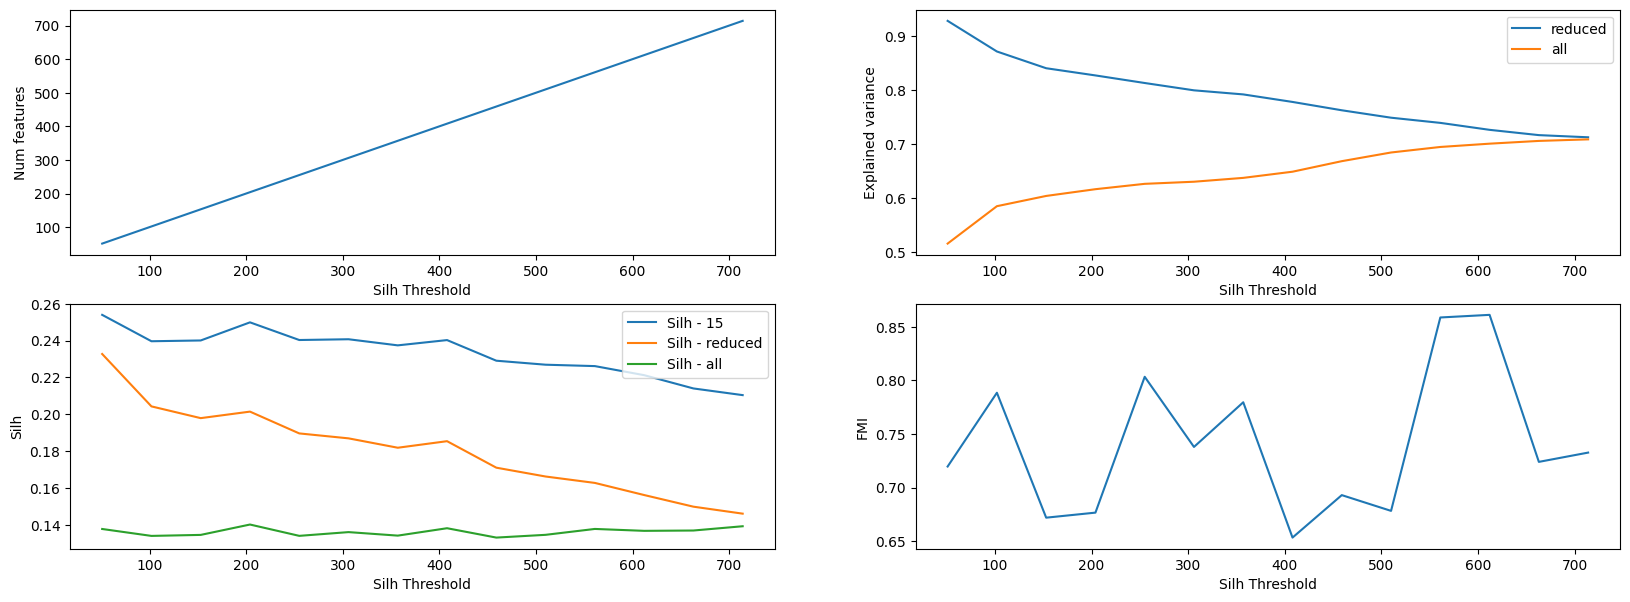

In [49]:
df_pca, fig_pca = test_thresholds(sklearn.decomposition.PCA(n_components = 15, svd_solver = "full", random_state = 42))

In [50]:
df_pca.to_csv(f"{subj}/{exp}/{features_type}/{function}/df_pca.csv", index = False)
fig_pca.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_pca.svg")
fig_pca.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_pca.png")

#### UMAP

100%|██████████| 14/14 [00:00<00:00, 13997.68it/s]


,num_features,explained_variances_reduced,explained_variances_all,fmi,silh_15,silh_reduced,silh_all
0,51,0.707201,0.419119,0.000000,0.000000,0.000000,0.000000
1,102,0.655814,0.438169,0.000000,0.000000,0.000000,0.000000
2,153,0.628757,0.443801,0.000000,0.000000,0.000000,0.000000
3,204,0.628524,0.461200,0.000000,0.000000,0.000000,0.000000
4,255,0.606831,0.458864,0.000000,0.000000,0.000000,0.000000
5,306,0.604791,0.464780,0.000000,0.000000,0.000000,0.000000
6,357,0.586483,0.459312,0.000000,0.000000,0.000000,0.000000
7,408,0.568991,0.460122,0.000000,0.000000,0.000000,0.000000
8,459,0.553502,0.466828,0.000000,0.000000,0.000000,0.000000
9,510,0.540601,0.463151,0.000000,0.000000,0.000000,0.000000


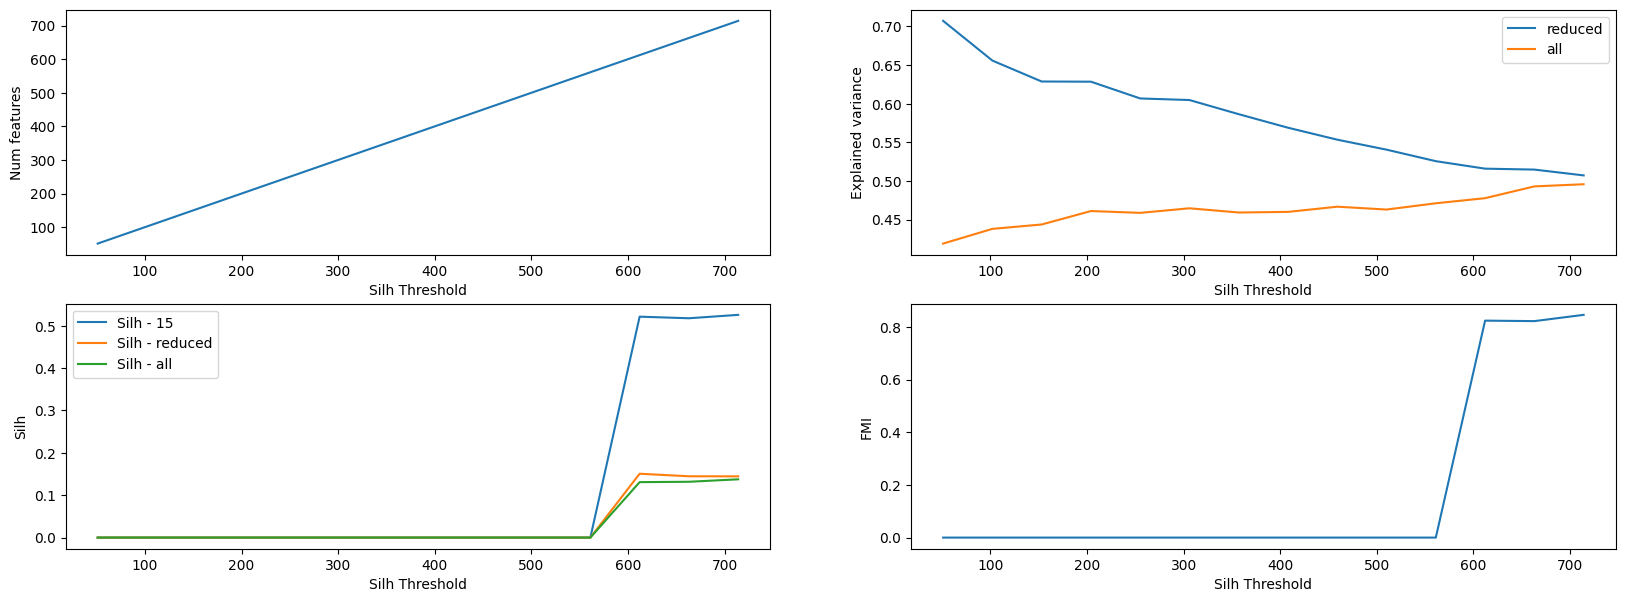

In [51]:
df_umap, fig_umap = test_thresholds(umap.UMAP(n_components = 15, random_state = 42))

In [52]:
df_umap.to_csv(f"{subj}/{exp}/{features_type}/{function}/df_umap.csv", index = False)
fig_umap.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_umap.svg")
fig_umap.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_umap.png")